# Pipelines for Druggable peptide classifiers using di-aminoacid composition descriptors (DC)

For each dataset, classifier and folds:
- scaling
- feature selection
- outerCV

In [114]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# remove warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [115]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score,f1_score, recall_score, precision_score
from sklearn.utils import class_weight

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFECV, VarianceThreshold, SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel, SelectPercentile, f_classif

import seaborn as sns; sns.set() # data visualization library 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from imblearn.over_sampling import SMOTE

### Define script parameters

In [118]:
# define output variables
outVars = ['Class']

# define list of folds
foldTypes = [3]

# define a label for output files
targetName = 'DC_Outer'

seed = 28

### Function definitions

In [119]:
def  set_weights(y_data, option='balanced'):
    """Estimate class weights for umbalanced dataset
       If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)). 
       If a dictionary is given, keys are classes and values are corresponding class weights. 
       If None is given, the class weights will be uniform """
    cw = class_weight.compute_class_weight(option, np.unique(y_data), y_data)
    w = {i:j for i,j in zip(np.unique(y_data), cw)}
    return w 

In [120]:
def DataCheckings(df):
    # CHECKINGS ***************************
    # Check the number of data points in the data set
    print("\nData points =", len(df))
    
    # Check the number of columns in the data set
    print("\nColumns (output + features)=",len(df.columns))
    
    # Check the data types
    print("\nData types =", df.dtypes.unique())
    
    # Dataset statistics
    print('\n')
    df.describe()
    
    # print names of columns
    print('Column Names:\n', df.columns)
    
    # see if there are categorical data
    print("\nCategorical features:", df.select_dtypes(include=['O']).columns.tolist())
    
    # Check NA values
    # Check any number of columns with NaN
    print("\nColumns with NaN: ", df.isnull().any().sum(), ' / ', len(df.columns))

    # Check any number of data points with NaN
    print("\nNo of data points with NaN:", df.isnull().any(axis=1).sum(), ' / ', len(df))

In [121]:
def getDataFromDataset(sFile, OutVar):
    # read details file
    print('\n-> Read dataset', sFile)
    df = pd.read_csv(sFile)
    #df = feather.read_dataframe(sFile)
    
    DataCheckings(df)
    
    # remove duplicates!
    df.drop_duplicates(keep=False, inplace=True)
    
    print('Shape', df.shape)
    # print(list(df.columns))

    # select X and Y
    ds_y = df[OutVar]
    ds_X = df.drop(OutVar,axis = 1)
    Xdata = ds_X.values # get values of features
    Ydata = ds_y.values # get output values

    print('Shape X data:', Xdata.shape)
    print('Shape Y data:',Ydata.shape)
    
    # return data for X and Y, feature names as list
    return (Xdata, Ydata, list(ds_X.columns))

In [122]:
OutVar = outVars[0]
folds  = foldTypes[0]

In [123]:
# get data from file
sFile = './datasets/ds.Class_DC.csv'
Xdata, Ydata, Features = getDataFromDataset(sFile,OutVar)
    
smote = SMOTE(ratio='minority',random_state=seed)
X_sm, y_sm = smote.fit_sample(Xdata, Ydata)


-> Read dataset ./datasets/ds.Class_DC.csv

Data points = 885

Columns (output + features)= 401

Data types = [dtype('float64') dtype('int64')]


Column Names:
 Index(['AA', 'RA', 'NA.', 'DA', 'CA', 'EA', 'QA', 'GA', 'HA', 'IA',
       ...
       'KV', 'MV', 'FV', 'PV', 'SV', 'TV', 'WV', 'YV', 'VV', 'Class'],
      dtype='object', length=401)

Categorical features: []

Columns with NaN:  0  /  401

No of data points with NaN: 0  /  885
Shape (885, 401)
Shape X data: (885, 400)
Shape Y data: (885,)


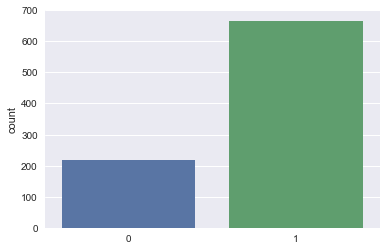

In [124]:
# unballanced dataset
ax = sns.countplot(Ydata,label="Count")      # count 1 and 0 in target

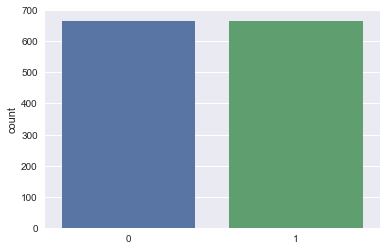

In [125]:
# ballanced dataset
ax = sns.countplot(y_sm,label="Count")      # count 1 and 0 in target

In [126]:
X_sm.shape

(1332, 400)

You can load the ballanced dataset or skip this block:

In [49]:
# save ballanced dataset
df_balanced = pd.DataFrame(X_sm,columns=Features)
df_balanced['Class']=y_sm
df_balanced.to_csv('./datasets/ds.Class_DC_ballanced.csv', index=False)

The main ML pipeline code:

In [127]:
def Pipeline_OuterCV(Xdata, Ydata, label = 'my', class_weights = {0: 1, 1: 1}, folds = 3, seed = 42):
    # inputs:
    # data for X, Y; a label about data, number of folds, seeed
    
    # default: 3-fold CV, 1:1 class weights (ballanced dataset)
    
    # define classifiers
    names = ['NB','KNN','LDA','SVM linear','SVM','LR','MLP','DT','RF','XGB','GB','AdaB','Bagging'] 
    
    
    priors = [(class_weights[0]/(class_weights[0]+class_weights[1])), (class_weights[1]/(class_weights[0]+class_weights[1]))]
    
    neurons = Xdata.shape[1] # neurons for MLP = number of input features
    
    classifiers = [GaussianNB(),
                   KNeighborsClassifier(3),
                   LinearDiscriminantAnalysis(solver='svd',priors=priors), # No tiene random_state
                   SVC(kernel="linear",random_state=seed,gamma='scale',class_weight=class_weights),
                   SVC(kernel = 'rbf', random_state=seed,gamma='scale',class_weight=class_weights),
                   LogisticRegression(solver='lbfgs',random_state=seed,class_weight=class_weights),
                   MLPClassifier(hidden_layer_sizes= (20), random_state = seed, max_iter=50000, shuffle=False),
                   DecisionTreeClassifier(random_state = seed,class_weight=class_weights),
                   RandomForestClassifier(n_jobs=-1,random_state=seed,class_weight=class_weights),
                   XGBClassifier(n_jobs=-1,seed=seed,scale_pos_weight= class_weights[0]/class_weights[1]),
                   GradientBoostingClassifier(random_state=seed),
                   AdaBoostClassifier(random_state = seed),
                   BaggingClassifier(random_state=seed)
                  ]
    # results dataframe: each column for a classifier
    df_res = pd.DataFrame(columns=names)

    # build each classifier
    print('* Building scaling+feature selection+outer '+str(folds)+'-fold CV for '+str(len(names))+' classifiers:', str(names))
    total = time.time()
    
    # define a fold-CV for all the classifier
    outer_cv = StratifiedKFold(n_splits=folds,shuffle=True,random_state=seed)
    
    print('ML method, Mean, SD, Time (min)')
    for name, clf in zip(names, classifiers):
        start = time.time()
        
        # create pipeline: scaler + classifier
        estimators = []
        
        # SCALER
        # MinMaxScaler(), StandardScaler(), RobustScaler(), QuantileTransformer(), PowerTransformer()
        estimators.append(( 'Scaler', StandardScaler() ))
        
        # FEATURE SELECTOR
        
        # estimators.append((  'FS', PCA(0.99)  )) # feature selection
        #estimators.append((  'FS', PCA(n_components=200)  )) # feature selection
        #estimators.append((  'FS', SelectPercentile(f_classif, percentile=50)  )) # feature selection
        #estimators.append((  'FS', VarianceThreshold(threshold=0.5)  )) # feature selection
        #estimators.append((  'FS', SelectFromModel(LinearSVC())  )) # feature selection 
        estimators.append((  'FS', SelectFromModel(LinearSVC(), max_features = 20,threshold=-np.inf)  ))
        #estimators.append((  'FS', SelectFromModel(ExtraTreesClassifier(n_estimators=100))  )) # feature selection 
        
        # add Classifier
        estimators.append(('Classifier', clf)) 
        
        # create pipeline
        model = Pipeline(estimators)
        
        # evaluate pipeline
        scores = cross_val_score(model, Xdata, Ydata, cv=outer_cv, scoring='roc_auc', n_jobs=-1)
        
        df_res[name] = scores
        print('%s, %0.3f, %0.4f, %0.1f' % (name, scores.mean(), scores.std(), (time.time() - start)/60))
        
    print('Total time:', (time.time() - total)/60, ' mins')             
    
    # return AUC scores for all classifiers as dataframe (each column a classifier)
    return df_res

In [128]:
class_weights = set_weights(y_sm)
print("Class weights = ", class_weights)

df_results = None # all results 

# try different folds for each subset -> box plots
for folds in foldTypes:
    df_fold = Pipeline_OuterCV(X_sm, y_sm, label = OutVar, class_weights = class_weights, folds = folds, seed = seed)
    df_fold['Dataset'] = OutVar
    df_fold['folds'] = folds

    # add each result to a summary dataframe
    df_results = pd.concat([df_results,df_fold])

Class weights =  {0: 1.0, 1: 1.0}
* Building scaling+feature selection+outer 3-fold CV for 13 classifiers: ['NB', 'KNN', 'LDA', 'SVM linear', 'SVM', 'LR', 'MLP', 'DT', 'RF', 'XGB', 'GB', 'AdaB', 'Bagging']
ML method, Mean, SD, Time (min)
NB, 0.782, 0.0131, 0.0
KNN, 0.840, 0.0013, 0.0
LDA, 0.788, 0.0064, 0.0
SVM linear, 0.781, 0.0143, 0.0
SVM, 0.895, 0.0103, 0.0
LR, 0.785, 0.0120, 0.0
MLP, 0.884, 0.0158, 0.0
DT, 0.764, 0.0247, 0.0
RF, 0.891, 0.0093, 0.0
XGB, 0.904, 0.0104, 0.0
GB, 0.906, 0.0100, 0.0
AdaB, 0.860, 0.0105, 0.0
Bagging, 0.890, 0.0246, 0.0
Total time: 0.17986830870310466  mins


In [129]:
# save all results
summaryFile = './results/DC.s.LinearSVC20.csv'
print('\n==>> Saving summary', summaryFile)
df_results.to_csv(summaryFile, index=False)
df_results


==>> Saving summary ./results/DC.s.LinearSVC20.csv


,NB,KNN,LDA,SVM linear,SVM,LR,MLP,DT,RF,XGB,GB,AdaB,Bagging,Dataset,folds
0,0.764193,0.838325,0.780639,0.781694,0.889416,0.784169,0.889843,0.786036,0.890451,0.896457,0.895382,0.862450,0.896173,Class,3
1,0.795725,0.841358,0.796303,0.798555,0.909768,0.800726,0.899196,0.777027,0.902737,0.919041,0.919528,0.870749,0.915936,Class,3
2,0.784616,0.840780,0.787923,0.763595,0.886657,0.771508,0.861984,0.729730,0.879920,0.897695,0.904391,0.845427,0.856657,Class,3


In [130]:
classifierNames = list(df_results.columns)
classifierNames.remove('Dataset')
classifierNames.remove('folds')
classifierNames

['NB',
 'KNN',
 'LDA',
 'SVM linear',
 'SVM',
 'LR',
 'MLP',
 'DT',
 'RF',
 'XGB',
 'GB',
 'AdaB',
 'Bagging']

In [131]:
foldTypes = list(set(df_results['folds']))
foldTypes.sort()
foldTypes

[3]

==> Fold = 3


<Figure size 432x288 with 0 Axes>

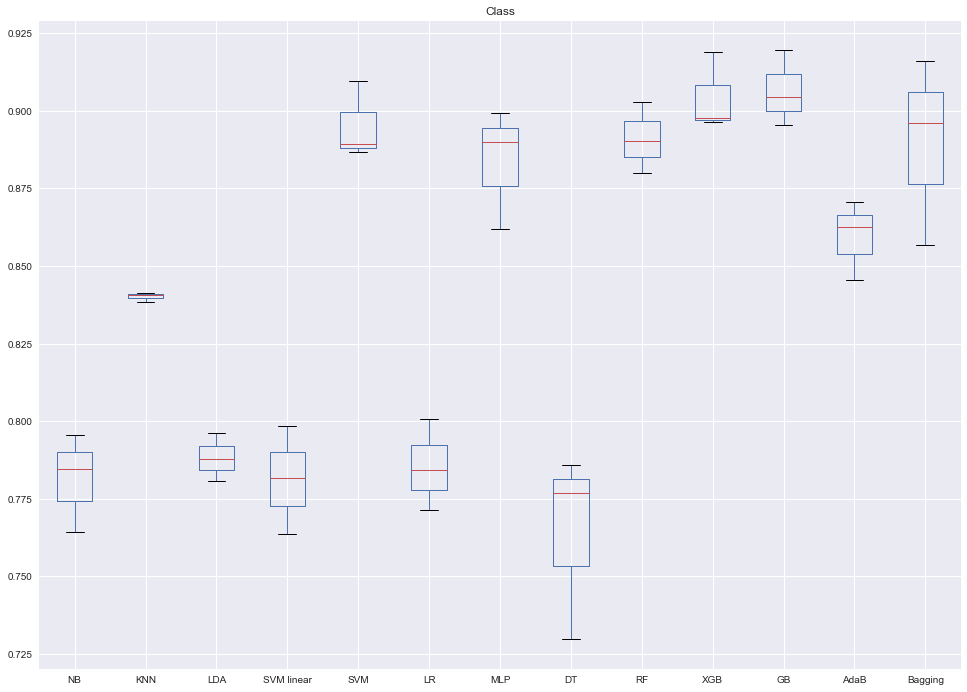

In [132]:
for f in foldTypes:
    plt.figure()
    plt.clf()
    print('==> Fold =', f)
    grouped = df_results[df_results['folds']==f].drop(['folds'], axis=1).groupby('Dataset')
    grouped.boxplot(figsize=(16,12), return_type='axes')
    plt.savefig('./results/DC.s.LinearSVC20.png')
    plt.show()

Have fun! @muntisa